Question 04

In [51]:
import cv2
import numpy as np

# Load the two images
img1 = cv2.imread('Images/graf/img1.ppm', cv2.IMREAD_GRAYSCALE)  # Load first image in grayscale
img2 = cv2.imread('Images/graf/img5.ppm', cv2.IMREAD_GRAYSCALE)  # Load second image in grayscale

# Initialize the SIFT detector
sift = cv2.SIFT_create()

# Detect SIFT features (keypoints and descriptors) in both images
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

# Use BFMatcher to find the best matches between descriptors
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Match descriptors from both images
matches = bf.match(descriptors1, descriptors2)

# Sort the matches based on their distances (lower distances are better)
matches = sorted(matches, key=lambda x: x.distance)

# Draw the top N matches
img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matched keypoints
cv2.imshow('SIFT Feature Matching', img_matches)
cv2.waitKey(0)
cv2.destroyAllWindows()


Computing Homography using RANSAC for consecutive images:
Homography between image 1 and 2:
[[ 8.76565004e-01  3.11828269e-01 -3.90987996e+01]
 [-1.84985352e-01  9.35265826e-01  1.53969985e+02]
 [ 1.91354419e-04 -1.72354297e-05  1.00000000e+00]]



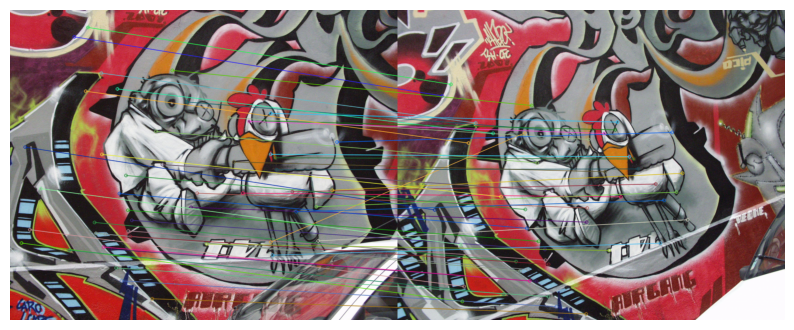

Homography between image 2 and 3:
[[ 6.73013427e-01 -5.29305270e-01  3.29608541e+02]
 [ 5.97967161e-01  8.66975777e-01 -1.85729304e+02]
 [ 1.57101283e-04 -4.86219742e-05  1.00000000e+00]]



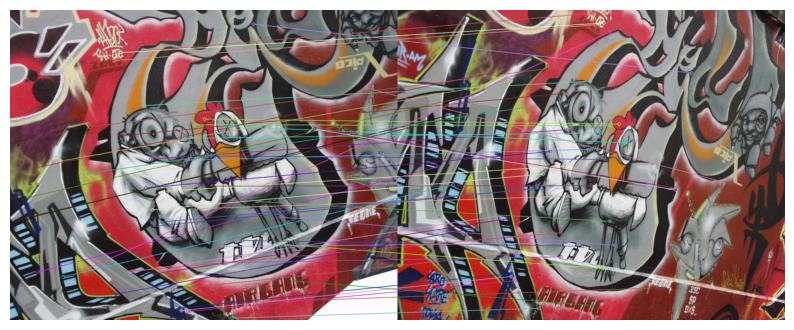

Homography between image 3 and 4:
[[ 5.60550662e-01  8.51068828e-01 -9.35555398e+01]
 [-7.00625355e-01  7.73885897e-01  3.70416468e+02]
 [ 1.07790323e-04  2.74133534e-05  1.00000000e+00]]



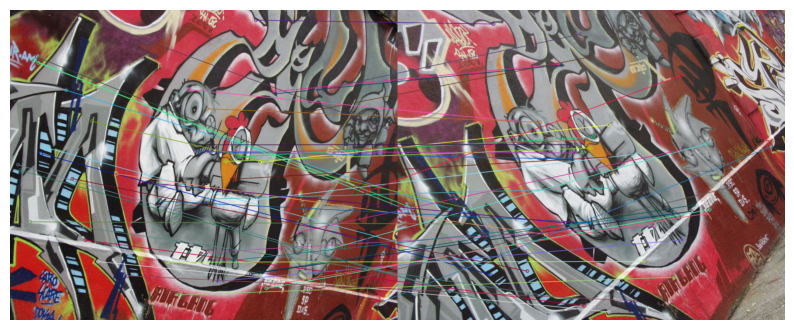

Homography between image 4 and 5:
[[ 6.42729658e-01 -3.93370341e-01  2.98641357e+02]
 [ 5.68778989e-01  7.63968159e-01 -1.18071979e+02]
 [ 6.46260812e-05 -9.04594201e-05  1.00000000e+00]]



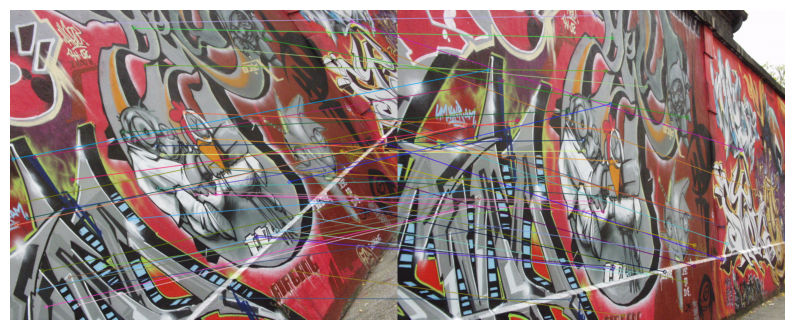

Final Homography (H15 from image 1 to image 5):
[[ 6.15361568e-01  5.53109052e-02  2.20749438e+02]
 [ 2.17576087e-01  1.13772994e+00 -2.17158337e+01]
 [ 4.84498014e-04 -6.10850979e-05  9.92417684e-01]]



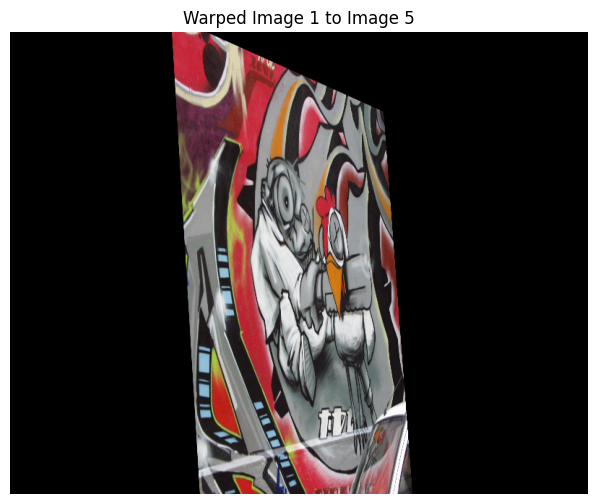

In [54]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the images
images = [cv2.imread(f'Images/graf/img{i}.ppm') for i in range(1, 6)]

# Initialize SIFT detector
sift = cv2.SIFT_create()

# FLANN based matcher
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=10)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Function to compute homography using RANSAC for two images
def compute_homography_ransac(img1, img2):
    # Detect keypoints and descriptors using SIFT
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # Match descriptors using FLANN matcher
    matches = flann.knnMatch(des1, des2, k=2)

    # Store all good matches using Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    # Extract location of good matches
    if len(good_matches) > 4:

        good_matches = random.sample(good_matches, min(50, len(good_matches)))
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # Compute Homography using RANSAC
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        return kp1, kp2, good_matches, H
    else:
        raise ValueError("Not enough matches found between the images")

# Function to plot matched keypoints
def plot_matches(img1, img2, kp1, kp2, matches):
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Hide axis
    plt.show()

# Compute RANSAC-based homographies between consecutive images
print("Computing Homography using RANSAC for consecutive images:")

H12 = compute_homography_ransac(images[0], images[1])
print(f"Homography between image 1 and 2:\n{H12[3]}\n")
plot_matches(images[0], images[1], H12[0], H12[1], H12[2])

H23 = compute_homography_ransac(images[1], images[2])
print(f"Homography between image 2 and 3:\n{H23[3]}\n")
plot_matches(images[1], images[2], H23[0], H23[1], H23[2])

H34 = compute_homography_ransac(images[2], images[3])
print(f"Homography between image 3 and 4:\n{H34[3]}\n")
plot_matches(images[2], images[3], H34[0], H34[1], H34[2])

H45 = compute_homography_ransac(images[3], images[4])
print(f"Homography between image 4 and 5:\n{H45[3]}\n")
plot_matches(images[3], images[4], H45[0], H45[1], H45[2])

# Compute the final homography H15 by multiplying all homographies from H12 to H45
H15 = H45[3] @ (H34[3] @ (H23[3] @ H12[3]))
print(f"Final Homography (H15 from image 1 to image 5):\n{H15}\n")

#Warp the first image to the fifth image using the final homography
height, width, channels = images[4].shape
img_warped = cv2.warpPerspective(images[0], H15, (width, height))

# Plot the warped image
plt.figure(figsize=(8, 6))
plt.title("Warped Image 1 to Image 5")
plt.imshow(cv2.cvtColor(img_warped, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Hide axis
plt.show()


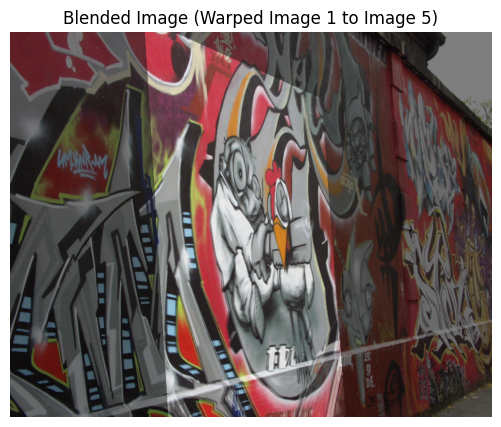

True

In [55]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Get the dimensions of image 5 (to warp image 1 into its perspective)
height5, width5 = images[4].shape[:2]

# Warp image 1 to image 5's perspective using homography H15
# We use the width and height of img5 to define the output size
warped_img1 = cv2.warpPerspective(images[0], H15, (width5, height5))

# Blend the warped image 1 and image 5 using a simple overlay technique
blended_image = cv2.addWeighted(warped_img1, 0.5, images[4], 0.5, 0)

# Plot the result using matplotlib
plt.figure(figsize=(10, 5))
plt.title("Blended Image (Warped Image 1 to Image 5)")
plt.imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Hide axes
plt.show()

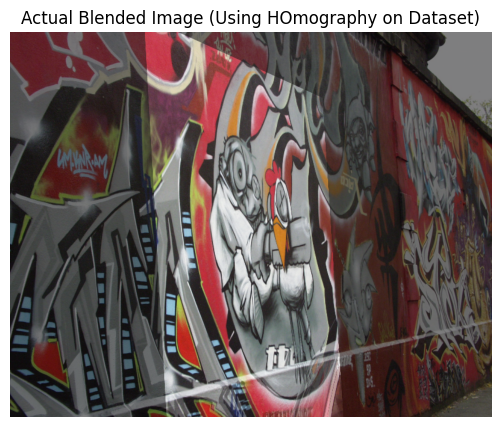

True

In [53]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Get the dimensions of image 5 (to warp image 1 into its perspective)
height5, width5 = images[4].shape[:2]

H15_data = np.array([[6.2544644e-01, 5.7759174e-02, 2.2201217e+02],
                     [2.2240536e-01, 1.1652147e+00, -2.5605611e+01],
                     [4.9212545e-04, -3.6542424e-05, 1.0000000e+00]])


# We use the width and height of img5 to define the output size
warped_img1 = cv2.warpPerspective(images[0], H15_data, (width5, height5))

# Blend the warped image 1 and image 5 using a simple overlay technique
blended_image = cv2.addWeighted(warped_img1, 0.5, images[4], 0.5, 0)

# Plot the result using matplotlib
plt.figure(figsize=(10, 5))
plt.title("Actual Blended Image (Using HOmography on Dataset)")
plt.imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Hide axes
plt.show()
